In [29]:
import pandas as pd

df = pd.read_csv("/Users/ebenezer/Documents/SleepApnea/Alldata/consolidated/summary_all_df.csv", delimiter=",")


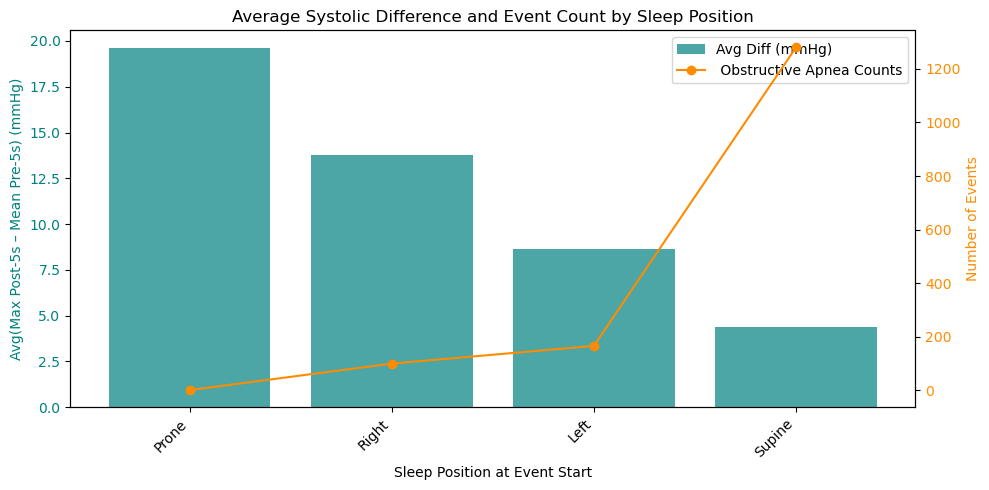

In [30]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv("/Users/ebenezer/Documents/SleepApnea/Alldata/consolidated/summary_all_df.csv", delimiter=",")
# Exclude rows where Systolic_mode is "Wake" or "Movement"
df = df[~df['Position_median'].isin(['Upright'])]

# 2. Identify Obstructive Apnea event start times and start-position for all subjects
oa_events = (
    df[df["Event name"] == "Obstructive Apnea"]
      .sort_values("Timestamp")
      .groupby(["Subject", "Rank"], as_index=False)
      .agg(
          Apnea_Start=("Timestamp", "first"),
          Position_Start=("Position_median", "first")
      )
)
oa_events = oa_events.rename(columns={"Rank": "OA_Rank"})

# 3. Compute mean pre-event & max post-event systolic per event
pre_stats = (
    df
      .merge(oa_events[["Subject","OA_Rank"]],
             left_on=["Subject","Pre_5"], right_on=["Subject","OA_Rank"],
             how="inner")
      .groupby(["Subject","OA_Rank"], as_index=False)
      .agg(Mean_Pre=("Systolic_median","mean"))
)
post_stats = (
    df
      .merge(oa_events[["Subject","OA_Rank"]],
             left_on=["Subject","Post_5"], right_on=["Subject","OA_Rank"],
             how="inner")
      .groupby(["Subject","OA_Rank"], as_index=False)
      .agg(Max_Post=("Systolic_median","max"))
)

# 4. Merge into comparison DataFrame and compute difference
comparison = (
    oa_events
      .merge(pre_stats, on=["Subject","OA_Rank"])
      .merge(post_stats, on=["Subject","OA_Rank"])
)
comparison["Diff"] = comparison["Max_Post"] - comparison["Mean_Pre"]

# 5. Group by Position_Start (all subjects) to get avg diff and event count
pos_stats = (
    comparison
      .groupby("Position_Start", as_index=False)
      .agg(Avg_Diff=("Diff","mean"), Event_Count=("Diff","size"))
      .sort_values("Avg_Diff", ascending=False)
)

# 6. Plot: dual-axis bar (avg diff) + line (event count)
fig, ax1 = plt.subplots(figsize=(10, 5))

positions = pos_stats["Position_Start"]
x = range(len(positions))

# Bar: average difference
ax1.bar(x, pos_stats["Avg_Diff"], color="teal", alpha=0.7, label="Avg Diff (mmHg)")
ax1.set_xlabel("Sleep Position at Event Start")
ax1.set_ylabel("Avg(Max Post-5s – Mean Pre-5s) (mmHg)", color="teal")
ax1.tick_params(axis="y", labelcolor="teal")
ax1.set_xticks(x)
ax1.set_xticklabels(positions, rotation=45, ha="right")

# Line: event count on secondary axis
ax2 = ax1.twinx()
ax2.plot(x, pos_stats["Event_Count"], color="darkorange", marker="o", label=" Obstructive Apnea Counts")
ax2.set_ylabel("Number of Events", color="darkorange")
ax2.tick_params(axis="y", labelcolor="darkorange")

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="upper right")

plt.title("Average Systolic Difference and Event Count by Sleep Position")
plt.tight_layout()
plt.show()

In [28]:
# 1. Identify Obstructive Apnea event starts and capture start position
oa_events = (
    df[df["Event name"] == "Obstructive Apnea"]
      .sort_values("Timestamp")
      .groupby(["Subject", "Rank"], as_index=False)
      .agg(
          Position_Start=("Position_median", "first")
      )
      .rename(columns={"Rank": "OA_Rank"})
)

# 2. Compute per-event mean(pre-5s) and max(post-5s) systolic
pre_stats = (
    df
      .merge(oa_events[["Subject","OA_Rank"]],
             left_on=["Subject","Pre_5"], right_on=["Subject","OA_Rank"],
             how="inner")
      .groupby(["Subject","OA_Rank"], as_index=False)
      .agg(Mean_Pre=("Systolic_median", "mean"))
)
post_stats = (
    df
      .merge(oa_events[["Subject","OA_Rank"]],
             left_on=["Subject","Post_5"], right_on=["Subject","OA_Rank"],
             how="inner")
      .groupby(["Subject","OA_Rank"], as_index=False)
      .agg(Max_Post=("Systolic_median", "max"))
)

# 3. Combine into comparison and compute difference
comparison = (
    oa_events
      .merge(pre_stats, on=["Subject","OA_Rank"])
      .merge(post_stats, on=["Subject","OA_Rank"])
)
comparison["Diff"] = comparison["Max_Post"] - comparison["Mean_Pre"]


output_file = "/Users/ebenezer/Documents/SleepApnea/Alldata/consolidated/Data_comparison.csv"
comparison.to_csv(output_file, index=False, na_rep="None") 

In [23]:
  pre_stats

,Subject,OA_Rank,Mean_Pre
0,1,3,203.7
1,1,4,187.9
2,1,5,186.9
3,1,24,197.8
4,1,51,194.3
...,...,...,...
1576,30,209,0.0
1577,30,212,0.0
1578,30,233,0.0
1579,30,234,26.4
